It's useful sometimes to write simple versions of complex things, so that you understand them. In this post we write a simple neural network from scratch.

In a normal classification problem, we have some labels \(y\) and inputs \(x\) and we would like to learn a linear function 


$$ y = W x $$ 

to separate the classes. Neural networks add an (or many!) extra layer 


$$ h = \mathrm{sigmoid}(M x) $$

between the inputs and output so that it produces is

$$ y = W h $$

Thus we are esentially fitting a linear classifier on the basis expansion \(\mathrm{sigmoid}(M x)\), the difference being that w efit the basis expansion, as well as the linear classifier. That is the Network learns a data dependent basis on which to clssify.

Enough with the maths, lets do some coding.

In [1]:
from __future__ import print_function
import numpy as np
np.random.seed(42)

Neural networks are made up of Layers, the simplest just returns what it recieves as input.

In [2]:
class Layer(object):
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    
    def __init__(self):
        """This is an identity layer so it doesn't need to do anything."""
        pass
    
    def forward(self, input):
        """
        Parameters
        ----------
        input : Tensor of shape [batch_size, num_input_units]
        
        Returns
        ----------
        output: Tensor of shape [batch_size, num_output_units]

        """
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        Parameters
        ----------
        input : Tensor of shape [batch_size, num_input_units]
        
        grad_output : Tensor of shape  [batch_size, num_input_units]
        
        Returns
        ----------
        
        grad_output : Tensor of shape [batch_size, num_output_units]
        
        """
        
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

Lets add some non-linearity layers: a ReLU layer, and a Sigmoid layer

In [3]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """
        Apply elementwise ReLU to [batch, input_units] matrix
        
        Parameters
        ----------
        input : Tensor of shape [batch_size, num_input_units]
        
        Returns
        ----------
        output: Tensor of shape [batch_size, num_output_units]

        """
        return np.maximum(0, input)
        
    
    def backward(self, input, grad_output):
        """
        Compute gradient of loss w.r.t. ReLU input
                
        Parameters
        ----------
        input : Tensor of shape [batch_size, num_input_units]
        
        grad_output : Tensor of shape  [batch_size, num_input_units]
        
        Returns
        ----------
        
        grad_output : Tensor of shape [batch_size, num_output_units]
        """
        relu_grad = input > 0
        return grad_output*relu_grad        

In [4]:
class Sigmoid(Layer):
    def __init__(self):
        """Sigmoid layer simply applies elementwise sigmoid unit to all inputs"""
        pass
    
    def forward(self, input):
        """
        Apply elementwise ReLU to [batch, input_units] matrix
        
        Parameters
        ----------
        input : Tensor of shape [batch_size, num_input_units]
        
        Returns
        ----------
        output: Tensor of shape [batch_size, num_output_units]

        """
        return np.tanh(input)
        
    
    def backward(self, input, grad_output):
        """
        Compute gradient of loss w.r.t. ReLU input
                
        Parameters
        ----------
        input : Tensor of shape [batch_size, num_input_units]
        
        grad_output : Tensor of shape  [batch_size, num_input_units]
        
        Returns
        ----------
        
        grad_output : Tensor of shape [batch_size, num_output_units]
        """
        sigmoid_grad = 1 - np.tanh(input)*np.tanh(input)
        return grad_output*sigmoid_grad        

We can test this by evaluating the numerical gradients:

In [5]:
def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    """Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/ (our ysda course).
    """
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print (ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

In [6]:
x = np.linspace(-1,1,10*32).reshape([10,32])
l = ReLU()
grads = l.backward(x,np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=x)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

In [7]:
x = np.linspace(-1,1,10*32).reshape([10,32])
l = Sigmoid()
grads = l.backward(x,np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=x)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

The next type of layer we will implement will be a Dense or Fully Connected layer. Unlike nonlinearity, this layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= W \cdot X + \vec b $$

Where 
* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs] 
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called.

In [8]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        
        Weights initialised by Xavier initialisation: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
        
        """
        self.learning_rate = learning_rate
        self.weights = np.random.randn(input_units, output_units) * np.sqrt(2.0/(input_units+output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        Parameters
        ----------
        input : Tensor of shape [batch_size, num_input_units]
        
        Returns
        ----------
        output: Tensor of shape [batch_size, num_output_units]
        """
        return input @ self.weights + self.biases
    
    def backward(self, input, grad_output):  
        """
        Parameters
        ----------
        input : Tensor of shape [batch_size, num_input_units]
        
        Returns
        ----------
        grad_output: Tensor of shape [batch_size, num_output_units]
        """
        grad_input = grad_output @ self.weights.T
        
        grad_weights = (input.T @ grad_output)
        grad_biases = grad_output.sum(axis=0)
  
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
    
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

Next, some tests:

In [9]:
l = Dense(128, 150)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))

In [10]:
x = np.linspace(-1,1,10*32).reshape([10,32])
l = Dense(32,64,learning_rate=0)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,64]))

assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0), "input gradient does not match numeric grad"

In [11]:
def compute_out_given_wb(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)
    
def compute_grad_by_params(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]) / 10.)
    return w - l.weights, b - l.biases
    
w,b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w,b).mean(0).sum(),w )
numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w,b).mean(0).sum(),b )
grad_w,grad_b = compute_grad_by_params(w,b)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"

We will optimise the following loss, which is a more numerically stable version of logg loss (courtesy of Coursera advanced ML):

In [12]:
def softmax_crossentropy_with_logits(logits, reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits, reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [13]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0)

We'll use the following function to load the mnist dataset:

In [14]:
def load_dataset(flatten=False):
    import keras
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

/Users/thomas.kealy/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [31]:
class Network(object):
    def __init__(self):
        network = []
        network.append(Dense(X_train.shape[1],100))
        network.append(ReLU())
        network.append(Dense(100,200))
        network.append(ReLU())
        network.append(Dense(200,10))
        self.network = network
    
    def forward(self, X):
        """
        comppute activations of all network layers by applying them sequentially.
        Return a list of activations for each layer. 
        Make sure last activation corresponds to network logits.
        """
        activations = []
        input = X

        for layer in self.network:
            activations.append(layer.forward(input))
            input = activations[-1]
        
        assert len(activations) == len(self.network)
        return activations

    def predict(self,X):
        """
        Compute network predictions.
        """
        logits = self.forward(X)[-1]
        return logits.argmax(axis=-1)

    def fit(self,X,y):
        """
        Train your network on a given batch of X and y.
        You first need to run forward to get all layer activations.
        Then you can run layer.backward going from last to first layer.
    
        After you called backward for all layers, all Dense layers have already made one gradient step.
        """
    
        # Get the layer activations
        layer_activations = self.forward(X)
        layer_inputs = [X]+layer_activations
        logits = layer_activations[-1]
    
        # Compute the loss and the initial gradient
        loss = softmax_crossentropy_with_logits(logits,y)
        loss_grad = grad_softmax_crossentropy_with_logits(logits,y)

        for layer_i in range(len(self.network))[::-1]:
            layer = self.network[layer_i]
        
            loss_grad = layer.backward(layer_inputs[layer_i],loss_grad) 
            
        return np.mean(loss)

Finally, we can train our nework!

In [32]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

Epoch 24
Train accuracy: 1.0
Val accuracy: 0.9819


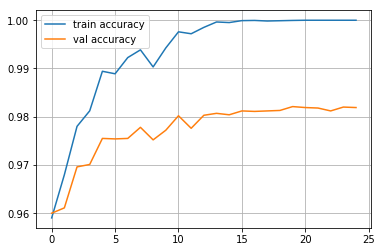

In [35]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

network = Network()
train_log = []
val_log = []

for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        network.fit(x_batch,y_batch)
    
    train_log.append(np.mean(network.predict(X_train)==y_train))
    val_log.append(np.mean(network.predict(X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()